In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os


In [5]:
## read heart.csv
## note: the first column is the index, so we skip it
## col names are age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
data = np.loadtxt('heart.csv', delimiter=',', dtype=None, skiprows=1)
column_names = os.popen('head -1 heart.csv').read().split(',')
x = data[:, :-1]
y = data[:, -1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=200, random_state=42)


k=1, Selected features: ['cp']
CV Error: 0.2400, Test Error: 0.2427
k=2, Selected features: ['cp', 'age']
CV Error: 0.2400, Test Error: 0.2816
k=3, Selected features: ['cp', 'age', 'thalach']
CV Error: 0.2400, Test Error: 0.2524
k=4, Selected features: ['cp', 'age', 'thalach', 'ca']
CV Error: 0.2050, Test Error: 0.2621
k=5, Selected features: ['cp', 'age', 'thalach', 'ca', 'exang']
CV Error: 0.1750, Test Error: 0.2427
k=6, Selected features: ['cp', 'age', 'thalach', 'ca', 'exang', 'thal']
CV Error: 0.1600, Test Error: 0.2233
k=7, Selected features: ['cp', 'age', 'thalach', 'ca', 'exang', 'thal', 'chol']
CV Error: 0.1600, Test Error: 0.2233
k=8, Selected features: ['cp', 'age', 'thalach', 'ca', 'exang', 'thal', 'chol', 'fbs']
CV Error: 0.1650, Test Error: 0.2330
k=9, Selected features: ['cp', 'age', 'thalach', 'ca', 'exang', 'thal', 'chol', 'fbs', 'slope']
CV Error: 0.1650, Test Error: 0.2136
k=10, Selected features: ['cp', 'age', 'thalach', 'ca', 'exang', 'thal', 'chol', 'fbs', 'slope'

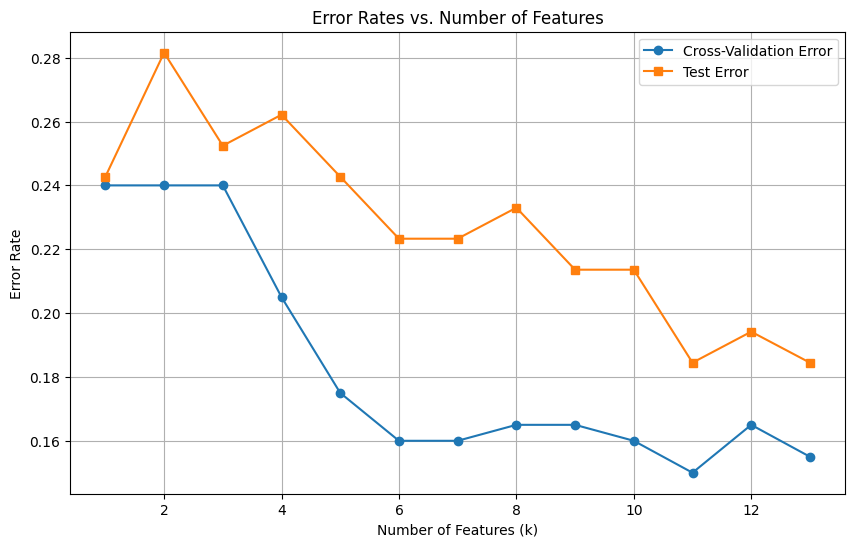


The two features selected for k=2 are: ['cp', 'age']


/home/scotty/ucsd/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/tmp/ipykernel_768852/4114364186.py:179: UserWarning: The following kwargs were not used by contour: 'legend'
  plt.contourf(xx, yy, Z, alpha=0.4,legend=True)


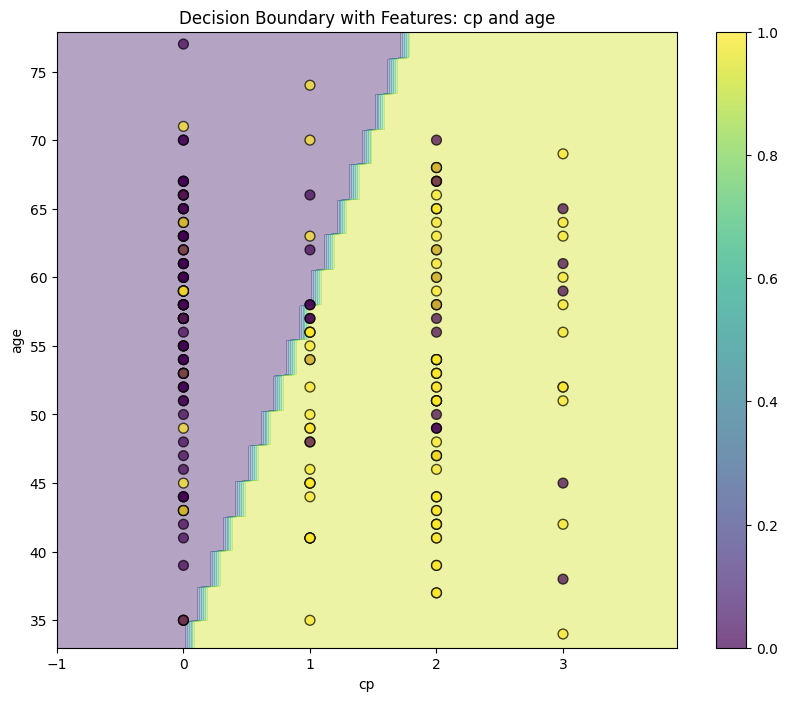

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Load the heart dataset
heart_data = pd.read_csv('heart.csv')

# Split features and target
X = heart_data.drop('target', axis=1)
y = heart_data['target']

# Get feature names for later reference
feature_names = X.columns.tolist()

# Split into training and test sets with specified parameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=200, random_state=42
)

def error_estimate(X, y, S):
    """
    Estimate the error of a logistic regression model using cross-validation.
    
    Parameters:
    -----------
    X : DataFrame
        The feature matrix
    y : Series
        The target variable
    S : list
        List of feature indices to use
        
    Returns:
    --------
    error : float
        The estimated error (1 - accuracy) from cross-validation
    """
    # If S is empty, return a high error
    if len(S) == 0:
        return 1.0
    
    # Select only the features in S
    X_selected = X.iloc[:, S]
    
    # Create a logistic regression model without regularization
    model = LogisticRegression(penalty=None, max_iter=10000)
    
    # Perform 5-fold cross-validation and get accuracy scores
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
    
    # Return the error (1 - mean accuracy)
    return 1.0 - np.mean(cv_scores)

def stepwise_forward_selection(X_train, y_train, k):
    """
    Perform stepwise forward selection to select k features.
    
    Parameters:
    -----------
    X_train : DataFrame
        The training feature matrix
    y_train : Series
        The training target variable
    k : int
        Number of features to select
        
    Returns:
    --------
    S : list
        Indices of the selected features
    """
    n_features = X_train.shape[1]
    
    # Initialize empty set of selected features
    S = []
    
    # Available features (all features initially)
    available_features = list(range(n_features))
    
    # Repeat k times
    for _ in range(min(k, n_features)):
        best_error = float('inf')
        best_feature = None
        
        # Try each feature not in S
        for feature in available_features:
            # Create candidate feature set
            candidate_set = S + [feature]
            
            # Estimate error with this feature added
            error = error_estimate(X_train, y_train, candidate_set)
            
            # Update best feature if this one gives lower error
            if error < best_error:
                best_error = error
                best_feature = feature
        
        # Add the best feature to S
        if best_feature is not None:
            S.append(best_feature)
            available_features.remove(best_feature)
    
    return S

# Run stepwise forward selection for k=1 to 13
k_values = range(1, 14)
cv_errors = []
test_errors = []
selected_features_by_k = {}

for k in k_values:
    # Select k best features
    selected_indices = stepwise_forward_selection(X_train, y_train, k)
    selected_features_by_k[k] = [feature_names[i] for i in selected_indices]
    
    # Get selected features for training and test sets
    X_train_selected = X_train.iloc[:, selected_indices]
    X_test_selected = X_test.iloc[:, selected_indices]
    
    # Train logistic regression model on selected features
    model = LogisticRegression(penalty=None, max_iter=10000)
    model.fit(X_train_selected, y_train)
    
    # Calculate cross-validation error
    cv_error = error_estimate(X_train, y_train, selected_indices)
    cv_errors.append(cv_error)
    
    # Calculate test error
    y_pred = model.predict(X_test_selected)
    test_error = 1.0 - accuracy_score(y_test, y_pred)
    test_errors.append(test_error)
    
    print(f"k={k}, Selected features: {selected_features_by_k[k]}")
    print(f"CV Error: {cv_error:.4f}, Test Error: {test_error:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_errors, 'o-', label='Cross-Validation Error')
plt.plot(k_values, test_errors, 's-', label='Test Error')
plt.xlabel('Number of Features (k)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs. Number of Features')
plt.legend()
plt.grid(True)
plt.savefig('error_vs_features.png')
plt.show()

# For k=2, plot the decision boundary
if 2 in selected_features_by_k:
    k2_features = selected_features_by_k[2]
    print(f"\nThe two features selected for k=2 are: {k2_features}")
    
    # Get indices of the two selected features
    feature_idx_1 = feature_names.index(k2_features[0])
    feature_idx_2 = feature_names.index(k2_features[1])
    
    # Train a model with just these two features
    X_train_k2 = X_train.iloc[:, [feature_idx_1, feature_idx_2]]
    X_test_k2 = X_test.iloc[:, [feature_idx_1, feature_idx_2]]
    
    model_k2 = LogisticRegression(penalty=None, max_iter=10000)
    model_k2.fit(X_train_k2, y_train)
    
    # Create a meshgrid for the decision boundary
    x_min, x_max = X_train_k2.iloc[:, 0].min() - 1, X_train_k2.iloc[:, 0].max() + 1
    y_min, y_max = X_train_k2.iloc[:, 1].min() - 1, X_train_k2.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on the meshgrid
    Z = model_k2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4,legend=True)
    plt.scatter(X_train_k2.iloc[:, 0], X_train_k2.iloc[:, 1], c=y_train, 
                s=50, edgecolors='k', alpha=0.7)
    plt.xlabel(k2_features[0])
    plt.ylabel(k2_features[1])
    plt.title(f'Decision Boundary with Features: {k2_features[0]} and {k2_features[1]}')
    plt.colorbar()
    plt.savefig('decision_boundary_k2.png')
    plt.show()

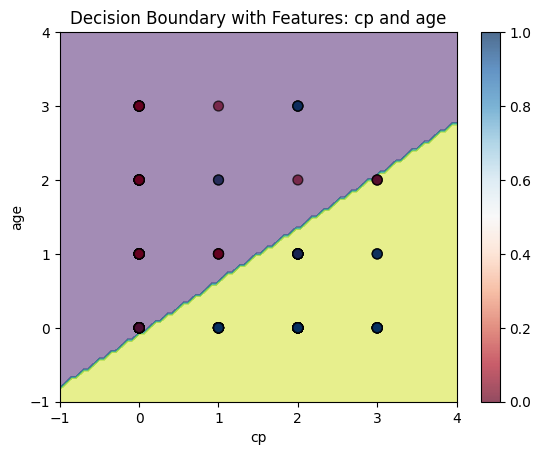

In [25]:
from sklearn.inspection import DecisionBoundaryDisplay

# Create the decision boundary display
disp = DecisionBoundaryDisplay.from_estimator(
    model_k2,
    X_train_k2,
    response_method="predict",
    alpha=0.5,
    xlabel=k2_features[0],
    ylabel=k2_features[1],
    grid_resolution=100
)

# Plot the training points
scatter = plt.scatter(
    X_train_k2[:, 0], 
    X_train_k2[:, 1], 
    c=y_train, 
    edgecolor='k',
    alpha=0.7,
    cmap=plt.cm.RdBu,
    s=50
)

# Add a colorbar and legend
plt.colorbar(scatter)
plt.title(f'Decision Boundary with Features: {k2_features[0]} and {k2_features[1]}')

# Save and show the plot
plt.savefig('decision_boundary_k2.png')
plt.show()

### QUICK GOOOO'G

1. Loading and Preparing Data...
Data loaded. Train set shape: (200, 13), Test set shape: (103, 13)
------------------------------
2. Defining Helper Functions...
Helper function ErrorEstimate defined.
------------------------------
3. Running Stepwise Forward Selection...
--- Selecting feature 1/13 ---
Selected feature 1: 'cp' (Index: 2)
  Current feature set (indices): [2]
  Current feature set (names): ['cp']
  Best CV Error for k=1: 0.2400
  Test Error for k=1: 0.2427
--- Selecting feature 2/13 ---
Selected feature 2: 'ca' (Index: 11)
  Current feature set (indices): [2, 11]
  Current feature set (names): ['cp', 'ca']
  Best CV Error for k=2: 0.2250
  Test Error for k=2: 0.3010
--- Selecting feature 3/13 ---
Selected feature 3: 'thal' (Index: 12)
  Current feature set (indices): [2, 11, 12]
  Current feature set (names): ['cp', 'ca', 'thal']
  Best CV Error for k=3: 0.1500
  Test Error for k=3: 0.2524
--- Selecting feature 4/13 ---
Selected feature 4: 'exang' (Index: 8)
  Current f

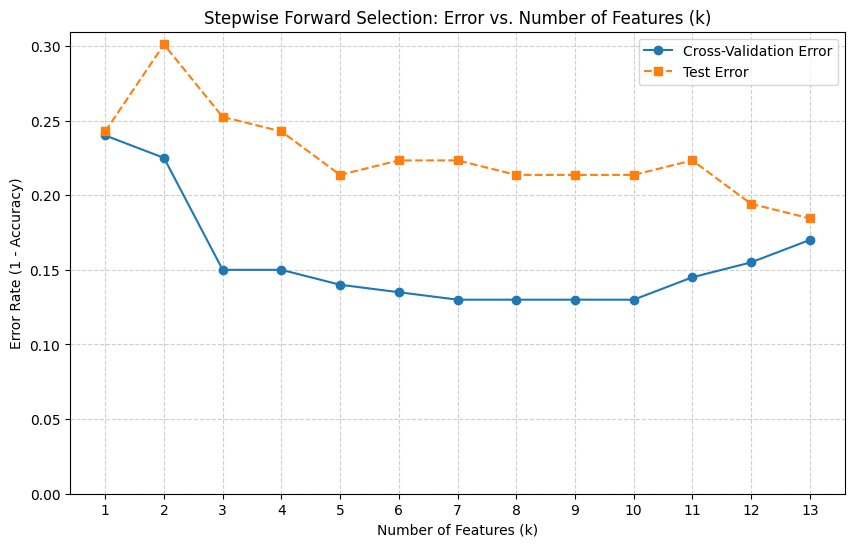

------------------------------
5. Analyzing Results for k=2...
Features selected for k=2:
- Index: 2, Name: 'cp'
- Index: 11, Name: 'ca'


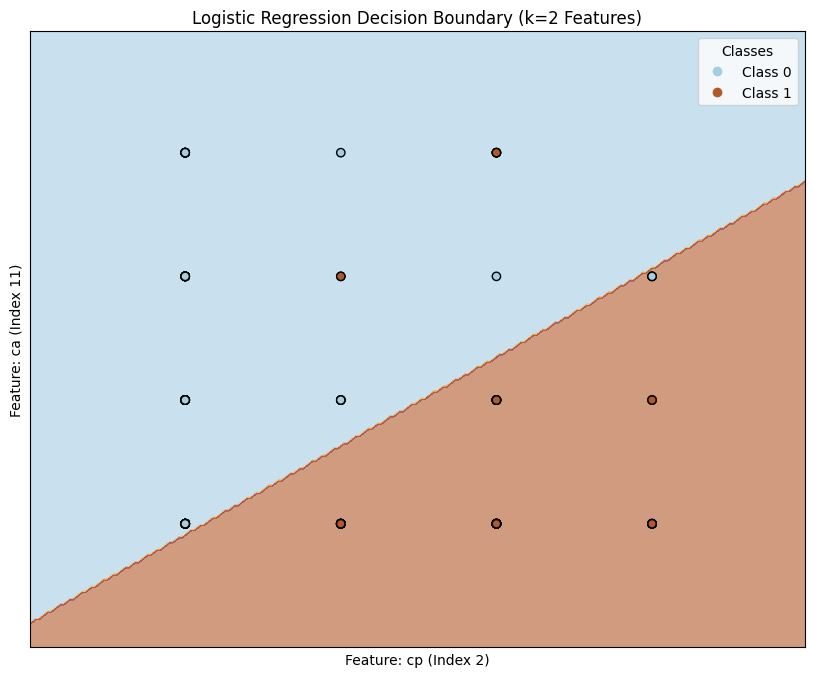

------------------------------
Analysis complete.


In [20]:
# %% Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time # To check computation time if needed

# %% Settings and Constants
DATA_URL = 'heart.csv'
TARGET_COLUMN = 'target'
N_FEATURES_TOTAL = 13 # As specified in the problem (13 coordinates)
TRAIN_SIZE = 200
TEST_SPLIT_RANDOM_STATE = 42
CV_FOLDS = 5 # Using 5-fold CV as a standard choice
LOGISTIC_PENALTY = None
# Increase max_iter significantly for non-regularized logistic regression
# Start high and adjust down if it's too slow but still converges.
LOGISTIC_MAX_ITER = 10000
LOGISTIC_SOLVER = 'liblinear' # Often works well, 'lbfgs' is default but might struggle more without penalty
LOGISTIC_RANDOM_STATE = 42 # For reproducibility of the solver itself

# %% Load and Prepare Data
print("1. Loading and Preparing Data...")
try:
    df = pd.read_csv(DATA_URL)
except Exception as e:
    print(f"Error loading data from {DATA_URL}: {e}")
    print("Please ensure the 'heart.csv' file is accessible or provide the correct path/URL.")
    # Exit or raise error if data loading fails
    exit()

# Separate features (X) and target (y)
try:
    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]
except KeyError:
    print(f"Error: Target column '{TARGET_COLUMN}' not found in the dataset.")
    print(f"Available columns: {df.columns.tolist()}")
    exit()

# Ensure correct number of features before proceeding
if X.shape[1] != N_FEATURES_TOTAL:
    print(f"Warning: Expected {N_FEATURES_TOTAL} features, but found {X.shape[1]}.")
    # Adjust N_FEATURES_TOTAL or investigate data discrepancy
    N_FEATURES_TOTAL = X.shape[1]
    print(f"Proceeding with {N_FEATURES_TOTAL} features found in the data.")


# Get feature names for later interpretation
feature_names = X.columns.tolist()

# Convert to NumPy arrays for sklearn compatibility
X_np = X.values
y_np = y.values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np,
    train_size=TRAIN_SIZE,
    random_state=TEST_SPLIT_RANDOM_STATE,
    #stratify=y_np # Good practice for classification tasks
)

print(f"Data loaded. Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("-" * 30)

# %% Helper Function: ErrorEstimate (Part 5a - Core Logic)
print("2. Defining Helper Functions...")

def ErrorEstimate(X_data, y_data, S, n_splits=CV_FOLDS, logistic_params=None):
    """
    Estimates the error of a logistic regression model using cross-validation.

    Args:
        X_data (np.ndarray): Feature data.
        y_data (np.ndarray): Target labels.
        S (list[int]): List of indices for the features to use.
        n_splits (int): Number of folds for cross-validation.
        logistic_params (dict): Parameters for LogisticRegression.

    Returns:
        float: Average cross-validation error (1 - accuracy).
               Returns float('inf') if S is empty or an error occurs.
    """
    if not S: # Handle empty feature set case if needed, though algorithm avoids this
        return float('inf')

    if logistic_params is None:
         logistic_params = {
             'penalty': LOGISTIC_PENALTY,
             'max_iter': LOGISTIC_MAX_ITER,
             'solver': LOGISTIC_SOLVER,
             'random_state': LOGISTIC_RANDOM_STATE # Ensure consistency within CV
         }

    # Select subset of features
    X_subset = X_data[:, S]

    if X_subset.shape[1] == 0: # Double check, should not happen with check above
         return float('inf')

    cv_errors = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=CV_FOLDS + 1) # Use different random state for KFold shuffling

    for train_index, val_index in kf.split(X_subset):
        X_train_cv, X_val_cv = X_subset[train_index], X_subset[val_index]
        y_train_cv, y_val_cv = y_data[train_index], y_data[val_index]

        try:
            model = LogisticRegression(penalty=None,max_iter=10000)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            accuracy = accuracy_score(y_val_cv, y_pred_cv)
            cv_errors.append(1 - accuracy)
        except Exception as e:
            # Handle potential convergence or other errors during CV fold fitting
            print(f"Warning: Error during CV fold for features {S}: {e}. Assigning high error.")
            cv_errors.append(1.0) # Assign max error for this fold

    return np.mean(cv_errors) if cv_errors else float('inf')

print("Helper function ErrorEstimate defined.")
print("-" * 30)

# %% Stepwise Forward Selection Algorithm (Part 5a & 5b - Implementation)
print("3. Running Stepwise Forward Selection...")

selected_features_indices = [] # List to store the indices of selected features at each step k
available_feature_indices = list(range(N_FEATURES_TOTAL)) # Indices of features not yet selected

cv_errors_per_k = [] # Store the best CV error found for each k
test_errors_per_k = [] # Store the test error for the model with k features
selected_features_history = {} # Store the actual set S for each k

logistic_params_final = {
    'penalty': LOGISTIC_PENALTY,
    'max_iter': LOGISTIC_MAX_ITER,
    'solver': LOGISTIC_SOLVER,
    'random_state': LOGISTIC_RANDOM_STATE # For final model training consistency
}

start_time = time.time()

for k in range(1, N_FEATURES_TOTAL + 1):
    print(f"--- Selecting feature {k}/{N_FEATURES_TOTAL} ---")
    best_feature_to_add = -1
    best_cv_error_for_k = float('inf')

    # Iterate through features *not* already selected
    for feature_idx in available_feature_indices:
        # Create candidate feature set
        candidate_features = selected_features_indices + [feature_idx]
        candidate_features.sort() # Keep consistent order (optional but good practice)

        # Estimate error with this potential feature added
        current_cv_error = ErrorEstimate(X_train, y_train, candidate_features)
        # print(f"  Testing feature {feature_names[feature_idx]} (idx {feature_idx}). CV Error: {current_cv_error:.4f}")


        # Check if this feature gives a better result
        if current_cv_error < best_cv_error_for_k:
            best_cv_error_for_k = current_cv_error
            best_feature_to_add = feature_idx

    # Add the best feature found in this iteration
    if best_feature_to_add != -1:
        selected_features_indices.append(best_feature_to_add)
        selected_features_indices.sort() # Maintain sorted order
        available_feature_indices.remove(best_feature_to_add)

        # Store results for this k
        cv_errors_per_k.append(best_cv_error_for_k)
        selected_features_history[k] = selected_features_indices.copy() # Store a copy

        # Train final model with the selected k features on the *entire* training set
        X_train_k = X_train[:, selected_features_indices]
        X_test_k = X_test[:, selected_features_indices]

        final_model_k = LogisticRegression(penalty=None,max_iter=10000)
        try:
            final_model_k.fit(X_train_k, y_train)
            y_pred_test_k = final_model_k.predict(X_test_k)
            test_error_k = 1 - accuracy_score(y_test, y_pred_test_k)
            test_errors_per_k.append(test_error_k)
        except Exception as e:
             print(f"Warning: Error fitting/predicting final model for k={k}: {e}. Assigning high test error.")
             test_errors_per_k.append(1.0) # Max test error

        selected_feature_names = [feature_names[i] for i in selected_features_indices]
        print(f"Selected feature {k}: '{feature_names[best_feature_to_add]}' (Index: {best_feature_to_add})")
        print(f"  Current feature set (indices): {selected_features_indices}")
        print(f"  Current feature set (names): {selected_feature_names}")
        print(f"  Best CV Error for k={k}: {best_cv_error_for_k:.4f}")
        print(f"  Test Error for k={k}: {test_errors_per_k[-1]:.4f}")

    else:
        print(f"Warning: Could not find a feature to add for k={k}. Stopping.")
        break # Should not happen if ErrorEstimate returns valid numbers

end_time = time.time()
print("-" * 30)
print(f"Stepwise selection completed in {end_time - start_time:.2f} seconds.")
print("-" * 30)


# %% Plotting Errors vs. k (Part 5b - Plot)
print("4. Plotting Cross-Validation and Test Errors...")

plt.figure(figsize=(10, 6))
k_values = range(1, len(cv_errors_per_k) + 1)
plt.plot(k_values, cv_errors_per_k, marker='o', linestyle='-', label='Cross-Validation Error')
plt.plot(k_values, test_errors_per_k, marker='s', linestyle='--', label='Test Error')

plt.title('Stepwise Forward Selection: Error vs. Number of Features (k)')
plt.xlabel('Number of Features (k)')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=0) # Error rate cannot be negative
plt.show()
print("-" * 30)

# %% Identify k=2 Features and Plot Decision Boundary (Part 5c)
print("5. Analyzing Results for k=2...")

k_target = 2
if k_target in selected_features_history:
    features_k2_indices = selected_features_history[k_target]
    features_k2_names = [feature_names[i] for i in features_k2_indices]
    print(f"Features selected for k={k_target}:")
    for i, name in zip(features_k2_indices, features_k2_names):
        print(f"- Index: {i}, Name: '{name}'")

    # Prepare data for plotting (using only the two selected features)
    X_train_k2 = X_train[:, features_k2_indices]
    X_test_k2 = X_test[:, features_k2_indices] # Although we plot boundary on train data

    # Train the final k=2 model again (or retrieve if stored)
    model_k2 = LogisticRegression(penalty=None,max_iter=10000)
    model_k2.fit(X_train_k2, y_train)

    # Create meshgrid for decision boundary plot
    x_min, x_max = X_train_k2[:, 0].min() - 1, X_train_k2[:, 0].max() + 1
    y_min, y_max = X_train_k2[:, 1].min() - 1, X_train_k2[:, 1].max() + 1
    h = 0.02 # Step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict on the meshgrid points
    Z = model_k2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.6)

    # Plot training points
    scatter = plt.scatter(X_train_k2[:, 0], X_train_k2[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
    plt.title(f'Logistic Regression Decision Boundary (k=2 Features)')
    plt.xlabel(f"Feature: {features_k2_names[0]} (Index {features_k2_indices[0]})")
    plt.ylabel(f"Feature: {features_k2_names[1]} (Index {features_k2_indices[1]})")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    # Create legend from scatter plot
    handles, labels = scatter.legend_elements()
    plt.legend(handles=handles, labels=['Class 0', 'Class 1'], title="Classes") # Adjust labels if necessary
    plt.show()

else:
    print(f"Could not retrieve results for k={k_target}. Check if the selection process completed successfully.")

print("-" * 30)
print("Analysis complete.")

### COMPLEMETS OF ELONGATED MUSK RAT A TAT TAT

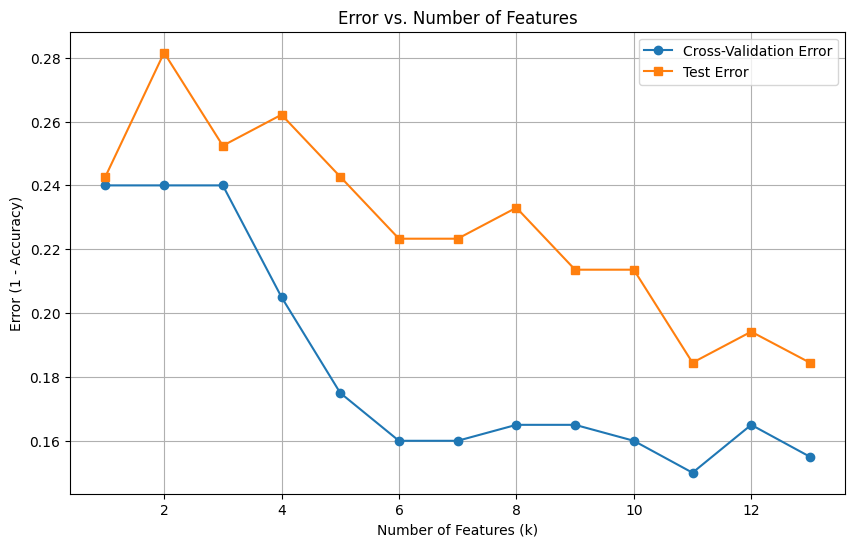

Features selected for k=2: ['cp', 'age']


/home/scotty/ucsd/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


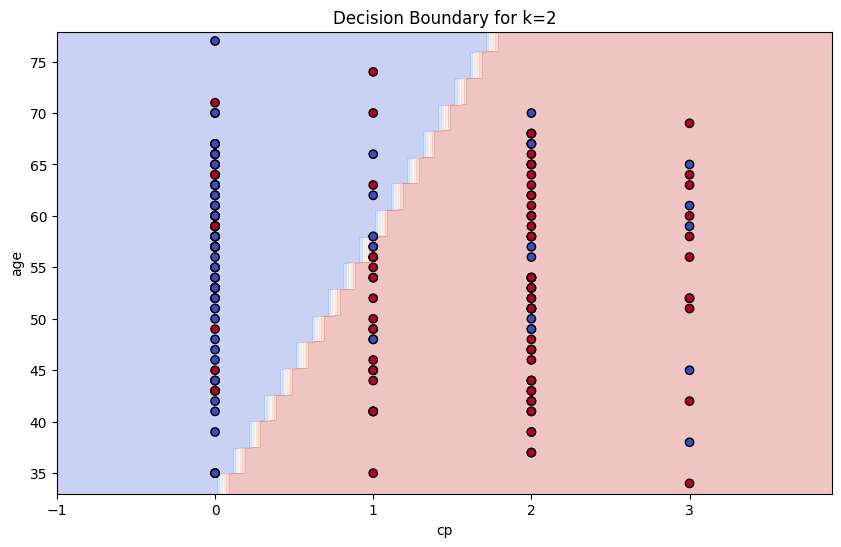

In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from itertools import combinations

# Load and preprocess the heart dataset
def load_heart_data():
    # Assuming heart.csv is in the working directory
    data = pd.read_csv('heart.csv')
    X = data.drop('target', axis=1)
    y = data['target']
    # Split data with specified parameters
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=200, random_state=42
    )
    return X_train, X_test, y_train, y_test, X.columns

# Function to estimate error using cross-validation
def ErrorEstimate(X, y, S):
    """
    Estimates the error of a logistic regression model using features S.
    
    Parameters:
    X: DataFrame, input features
    y: Series, target variable
    S: list, selected feature indices or names
    
    Returns:
    float, mean cross-validation error (1 - accuracy)
    """
    if not S:  # Handle empty feature set
        return 1.0
    # Subset data to selected features
    X_subset = X[S]
    # Initialize logistic regression with no regularization
    model = LogisticRegression(penalty=None, max_iter=10000, random_state=42)
    # Compute cross-validation scores (accuracy)
    scores = cross_val_score(model, X_subset, y, cv=5, scoring='accuracy')
    # Return error estimate (1 - mean accuracy)
    return 1 - np.mean(scores)

# Stepwise forward selection algorithm
def stepwise_forward_selection(X, y, k, feature_names):
    """
    Performs stepwise forward selection to select k features.
    
    Parameters:
    X: DataFrame, input features
    y: Series, target variable
    k: int, number of features to select
    feature_names: Index, names of features
    
    Returns:
    list, selected feature names
    """
    S = []  # Selected features
    remaining_features = list(feature_names)
    
    for _ in range(min(k, len(feature_names))):
        best_error = float('inf')
        best_feature = None
        
        # Evaluate each feature not in S
        for f in remaining_features:
            # Estimate error with current S plus new feature
            error = ErrorEstimate(X, y, S + [f])
            if error < best_error:
                best_error = error
                best_feature = f
        
        if best_feature is not None:
            S.append(best_feature)
            remaining_features.remove(best_feature)
    
    return S

# Compute test error for a given feature set
def compute_test_error(X_train, X_test, y_train, y_test, S):
    """
    Computes test error for a logistic regression model using features S.
    
    Parameters:
    X_train, X_test: DataFrames, training and test features
    y_train, y_test: Series, training and test targets
    S: list, selected feature names
    
    Returns:
    float, test error (1 - accuracy)
    """
    if not S:
        return 1.0
    # Subset data
    X_train_subset = X_train[S]
    X_test_subset = X_test[S]
    # Fit model
    model = LogisticRegression(penalty=None, max_iter=10000, random_state=42)
    model.fit(X_train_subset, y_train)
    # Compute test accuracy
    test_accuracy = model.score(X_test_subset, y_test)
    return 1 - test_accuracy

# Main execution
def main():
    # Load data
    X_train, X_test, y_train, y_test, feature_names = load_heart_data()
    
    # Lists to store errors
    cv_errors = []
    test_errors = []
    selected_features_all = []
    
    # Run stepwise selection for k=1 to 13
    for k in range(1, 14):
        # Select k features
        selected_features = stepwise_forward_selection(X_train, y_train, k, feature_names)
        selected_features_all.append(selected_features)
        
        # Compute cross-validation error
        cv_error = ErrorEstimate(X_train, y_train, selected_features)
        cv_errors.append(cv_error)
        
        # Compute test error
        test_error = compute_test_error(X_train, X_test, y_train, y_test, selected_features)
        test_errors.append(test_error)
    
    # Plot errors
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 14), cv_errors, label='Cross-Validation Error', marker='o')
    plt.plot(range(1, 14), test_errors, label='Test Error', marker='s')
    plt.xlabel('Number of Features (k)')
    plt.ylabel('Error (1 - Accuracy)')
    plt.title('Error vs. Number of Features')
    plt.legend()
    plt.grid(True)
    #plt.savefig('error_vs_k.png')
    plt.show()
    
    # For k=2, get selected features
    k2_features = selected_features_all[1]  # Index 1 corresponds to k=2
    print(f"Features selected for k=2: {k2_features}")
    
    # Plot decision boundary for k=2
    if len(k2_features) == 2:
        # Create mesh grid for decision boundary
        X_subset = X_train[k2_features]
        x_min, x_max = X_subset.iloc[:, 0].min() - 1, X_subset.iloc[:, 0].max() + 1
        y_min, y_max = X_subset.iloc[:, 1].min() - 1, X_subset.iloc[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                            np.arange(y_min, y_max, 0.1))
        
        # Fit model on selected features
        model = LogisticRegression(penalty=None, max_iter=10000, random_state=42)
        model.fit(X_subset, y_train)
        
        # Predict on mesh grid
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        plt.scatter(X_subset.iloc[:, 0], X_subset.iloc[:, 1], c=y_train, edgecolors='k', cmap='coolwarm')
        plt.xlabel(k2_features[0])
        plt.ylabel(k2_features[1])
        plt.title('Decision Boundary for k=2')
        #plt.savefig('decision_boundary_k2.png')
        plt.show()

main()